In [327]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from non_parametric_collocation import collocate_data

# pyomo
import importlib
import nn_pyomo

importlib.reload(nn_pyomo)
NeuralODEPyomo = nn_pyomo.NeuralODEPyomo

collocation_path = os.path.abspath(os.path.join('..', 'utils'))

if collocation_path not in sys.path:
    sys.path.append(collocation_path)
    
from interpolation import BarycentricInterpolation

import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d

### Data Generation

In [328]:
def generate_chebyshev_nodes(n, start, end):
    k = np.arange(n)
    x = np.cos(np.pi * k / (n - 1))
    nodes = 0.5 * (end - start) * x + 0.5 * (start + end)
    return np.sort(nodes)

In [395]:
def load_data(file_path, start_date, number_of_points):

    data = pd.read_csv(file_path)
    data_subsample = data[data.settlement_date >= start_date]
    # data_subsample = data_subsample[data_subsample.settlement_date < '2010-01-10']
    data_subsample = data_subsample[:number_of_points]
    data_subsample.reset_index(drop=True, inplace=True)

    data_subsample['settlement_date'] = pd.to_datetime(data_subsample['settlement_date'])
    data_subsample.loc[:,'hour'] = data_subsample['settlement_date'].dt.hour

    # select the main columns for the intial testing
    data_subsample = data_subsample[['settlement_date', 'temperature', 'hour', 'nd']]

    print(f"The first/ last time points in the subsample are {np.min(data_subsample.settlement_date)}/ {np.max(data_subsample.settlement_date)}")
    print(f"Covering {np.max(data_subsample['settlement_date'].dt.day) - np.min(data_subsample['settlement_date'].dt.day)} days")

    t = jnp.linspace(0., 1., data_subsample.shape[0]) 

    # How many points cover one day?   
    one_day_map = (data_subsample['settlement_date'].dt.day == np.min(data_subsample['settlement_date'].dt.day))
    n_pt_per_day = one_day_map.sum()
    print(f"Number of points per day: {n_pt_per_day}")

    one_day_offset = (1/data_subsample.shape[0]) * n_pt_per_day
    print(f"Time offset needed for 1 day: {one_day_offset}")

    data_subsample.rename(columns={'settlement_date': 'date', 'temperature': 'var1', 'hour':'var2', 'nd':'y'}, inplace=True)
    data_subsample['t'] = t
    
    return data_subsample

In [441]:
def preprocessing(data_subsample, tau, m, sigma = 1, split = 300, num_nodes_mult = 1, equally_spaced = False):
    """
    Args:
        data_subsample (dataframe): dataframe containing the subsample of the data;
        expected column names are: 'y', 'date', 'var1', 'var2' ect.
        tau (float): number of points per lag
        m (int): number of lags
    """
    d = data_subsample.copy()   
    columns = data_subsample.columns
    if 't' not in columns:
        raise ValueError("The time column is not present in the dataframe")
    if 'y' not in columns:
        raise ValueError("The target column is not present in the dataframe")
    
    t, y = data_subsample['t'], data_subsample['y']
    
    #----------------------------- SMOOTHING -----------------------------#
    y = gaussian_filter1d(y, sigma = sigma)
    d['y'] = y
    
    #--------------------------------- LAGS -----------------------------#
    for i in range(1, m+1):
        d[f'y_lag{i}'] = d['y'].shift(tau*i)
            
    # the first point that has the last lag available
    first_index = d[f'y_lag{i}'].index[~d[f'y_lag{i}'].isna()][0]

    # drop rows where time lags are not available
    # subtract the first index from the split point 
    split -= first_index
    d = d.iloc[first_index:]
    t = d['t'] 
    
    ##### ------------------------------------------------------------------ --------------------------------TRAIN TEST SPLIT RATIO #####
    #split = int(0.75 * len(t)) 
    t_train, t_test = t[:split], t[split:]

    print(f"Training data: {t_train.shape[0]} timepoints")
    print(f"Training data: {t_test.shape[0]} timepoints")

    ##### ------------------------------------------------------------------ --------------------------------TRAIN DATA SIZE MULTIPLIES #####
    #-------------------- CHEBYSHEV NODES FOR THE TRAIN DATA ---------------------#
    if equally_spaced:
        num_nodes = len(t_train)*num_nodes_mult
        t_train = generate_chebyshev_nodes(num_nodes, t_train.min(), t_train.max())
    else:
        num_nodes = len(t_train)*num_nodes_mult
        t_train = np.linspace(t_train.min(), t_train.max(), num_nodes)
    
    #------------------------- INTERPOLATION FUNCTIONS ---------------------------#

    var_cols_map = ['var' in col for col in d.columns]
    var_cols = d.columns[var_cols_map]
    
    # 1. fit interpolation functions 
    # 2. geneate data
    # 3. save to a new dataframe
    
    interpolated_data_train = {}
    interpolated_data_test = {}
    
    # INDEPENDENT VARIABLES
    for var in var_cols:
        cs = CubicSpline(t, d[var])
        interpolated_data_train[var] = cs(t_train)
        interpolated_data_test[var] = cs(t_test)
        
    # DEPENDENT VARIABLES    
    cs_y = CubicSpline(t, d['y'])
    interpolated_data_train['y'] = cs_y(t_train)
    interpolated_data_test['y'] = cs_y(t_test)
    
    # LAGGED DEPENDENT VARIABLES
    for i in range(1, m+1):
        cs = CubicSpline(t, d[f'y_lag{i}'])
        interpolated_data_train[f'y_lag{i}'] = cs(t_train)
        # here we need some logic to reuse the data available from the training set
        interpolated_data_test[f'y_lag{i}'] = cs(t_test)
        # this gives the whole range, but we need to cut it off where the training data ends
        offset = tau*i # points are needed for the lag
        for p in range(offset, len(t_test)):
            interpolated_data_test[f'y_lag{i}'][p] = np.nan
        
    # TIME
    interpolated_data_train['t'] = t_train
    interpolated_data_test['t'] = t_test

    print(f"Training data: {t_train.shape[0]} timepoints after interpolation")
    
    df_train = pd.DataFrame(interpolated_data_train)
    df_test = pd.DataFrame(interpolated_data_test)

    #------------------------- SCALE ---------------------------#
    scaler = StandardScaler()
    
    columns_to_scale = df_train.columns.difference(['t'])
    df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
    df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])
    
    return df_train, df_test

In [398]:
file_path = 'df_train.csv'
start_date = '2010-01-10'
number_of_points = 400

data_subsample = load_data(file_path, start_date, number_of_points)
df_train, df_test = preprocessing(data_subsample, 48, 2)

The first/ last time points in the subsample are 2010-01-10 00:00:00/ 2010-01-18 07:30:00
Covering 8 days
Number of points per day: 48
Time offset needed for 1 day: 0.12
Training data: 204 timepoints
Training data: 100 timepoints
Training data: 204 timepoints after interpolation


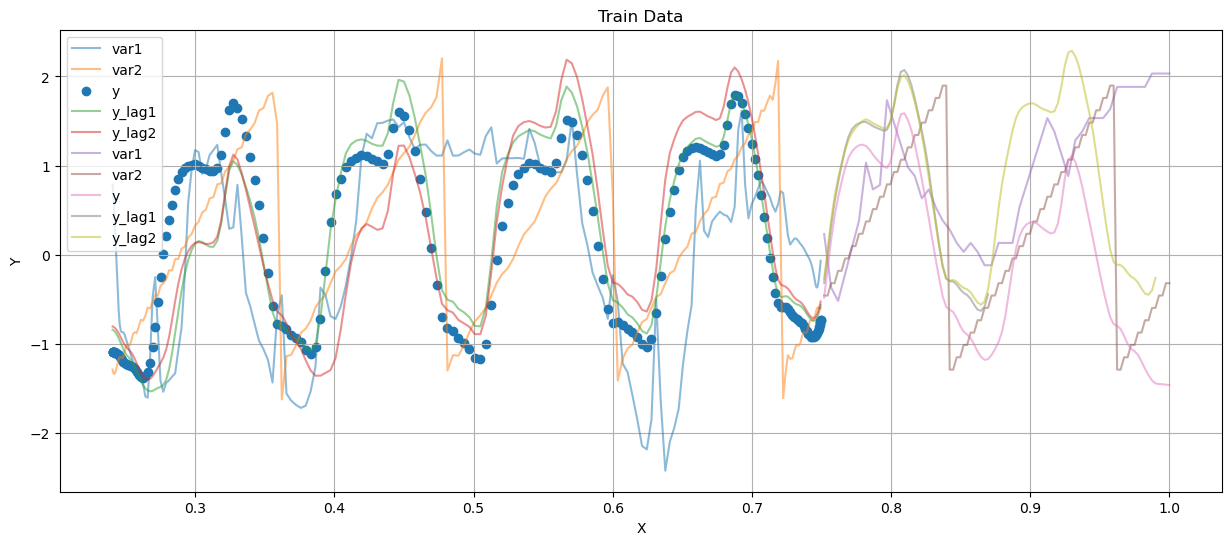

In [378]:
if True:
    plt.figure(figsize=(15, 6))
    for col in df_train.columns.difference(['t']):
        if col == 'y':
            plt.scatter(df_train['t'], df_train[col], label=col, alpha=1)
            continue
        plt.plot(df_train['t'], df_train[col], '-', label=col, alpha=0.5)
        
    for col in df_test.columns.difference(['t']):
        plt.plot(df_test['t'], df_test[col], '-', label=col, alpha=0.5)
    #plt.plot(t_train, y_train_scaled, '-', label='X_train_scaled', alpha=0.5)
    #plt.plot(x_train_cheb_lags, Xs[:,:2], 'b-', label='Dependent Variables', alpha=0.4, ls = '--')

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Train Data')
    plt.grid(True)
    plt.show()

In [379]:
ys = np.atleast_2d(df_train['y']).T
ts = np.array(df_train['t'])
Xs = np.array(df_train.drop(columns=['y', 't']))

In [380]:
weights = compute_weights(ts)
Ds = np.array(lagrange_derivative(ts, weights))

In [392]:
for i in range(1, 25, 5):
    start_date = f'2010-01-{i:02d}'
    print(start_date)

2010-01-01
2010-01-06
2010-01-11
2010-01-16
2010-01-21


In [408]:
len(ts)

208

The first/ last time points in the subsample are 2011-01-01 00:00:00/ 2011-01-17 15:30:00
Covering 16 days
Number of points per day: 48
Time offset needed for 1 day: 0.06
Training data: 208 timepoints
Training data: 400 timepoints
Training data: 208 timepoints after interpolation
y
Ipopt 3.14.16: tol=1e-08
dual_inf_tol=1e-08
compl_inf_tol=1e-08
constr_viol_tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 24.657078981399536, 'termination_condition'

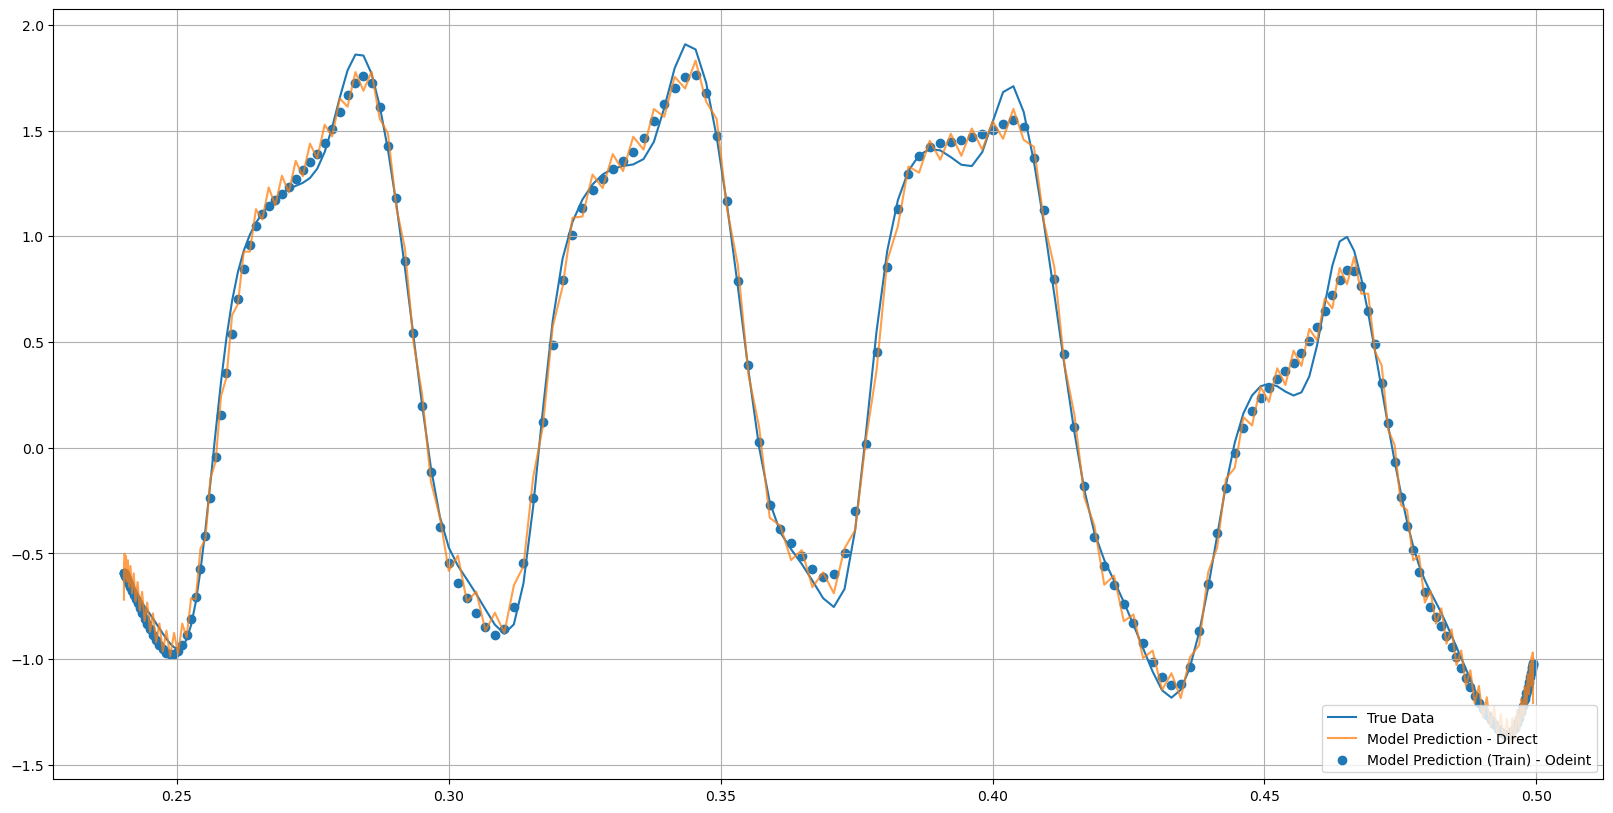

The first/ last time points in the subsample are 2011-01-06 00:00:00/ 2011-01-22 15:30:00
Covering 16 days
Number of points per day: 48
Time offset needed for 1 day: 0.06
Training data: 208 timepoints
Training data: 400 timepoints
Training data: 208 timepoints after interpolation
y
Ipopt 3.14.16: tol=1e-08
dual_inf_tol=1e-08
compl_inf_tol=1e-08
constr_viol_tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 25.517038822174072, 'termination_condition'

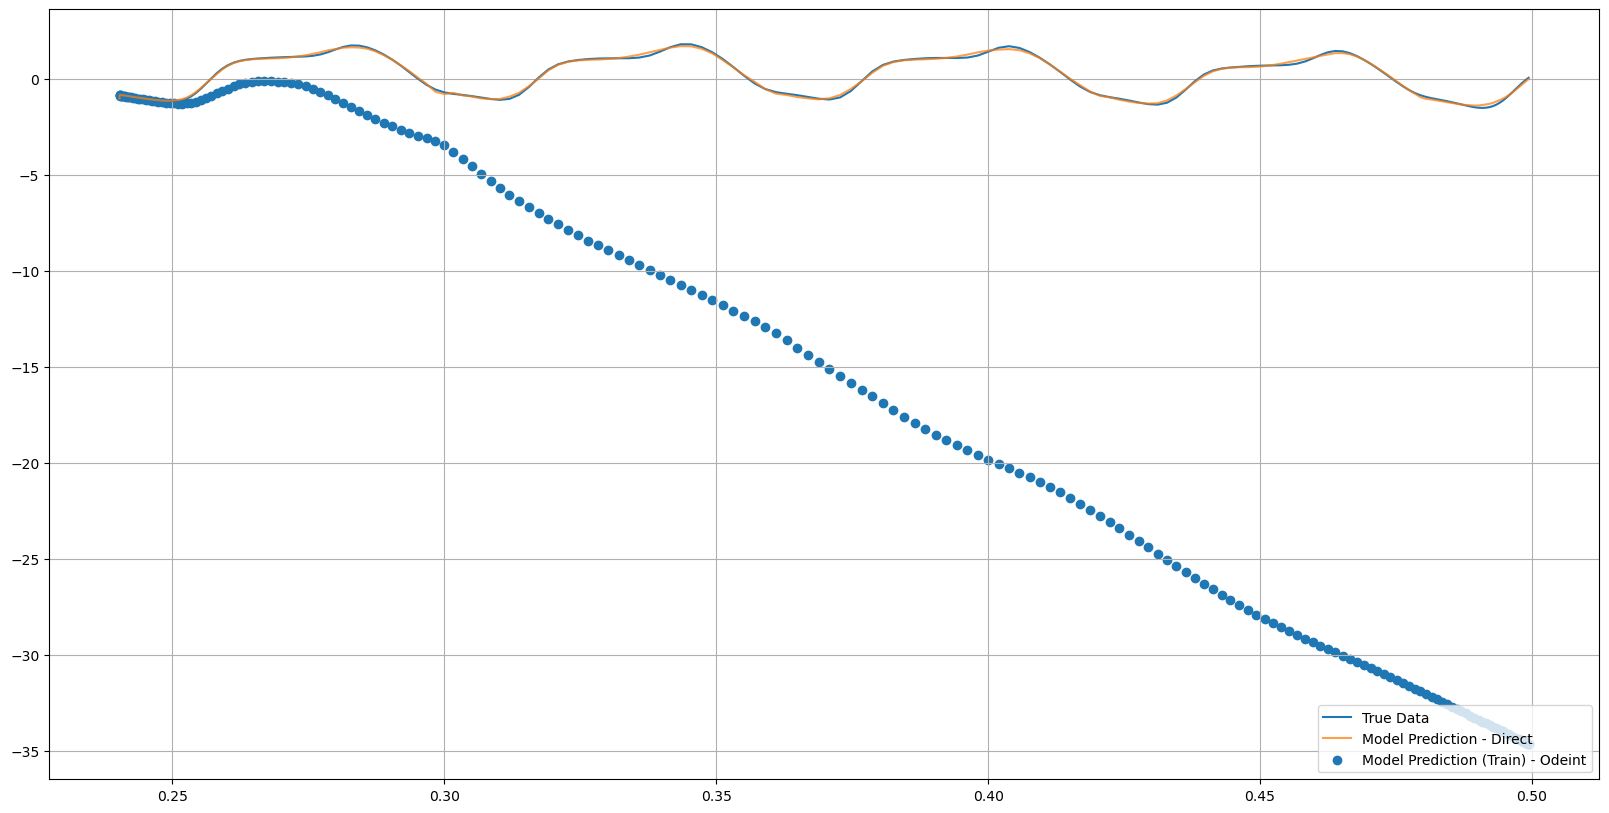

The first/ last time points in the subsample are 2011-01-11 00:00:00/ 2011-01-27 15:30:00
Covering 16 days
Number of points per day: 48
Time offset needed for 1 day: 0.06
Training data: 208 timepoints
Training data: 400 timepoints
Training data: 208 timepoints after interpolation
y
Ipopt 3.14.16: tol=1e-08
dual_inf_tol=1e-08
compl_inf_tol=1e-08
constr_viol_tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 50.846983194351196, 'termination_condition'

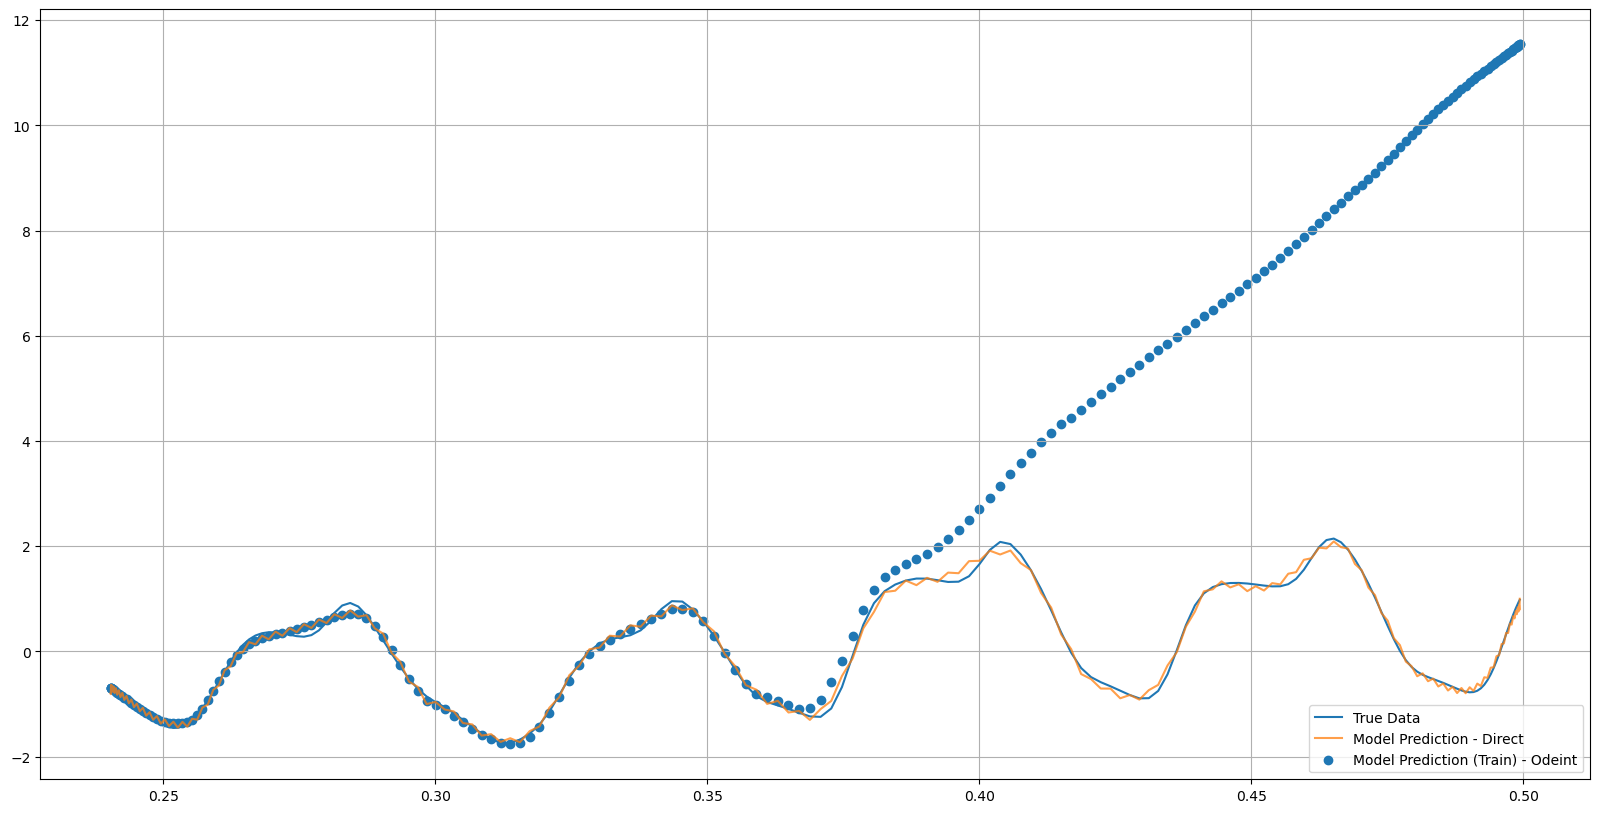

The first/ last time points in the subsample are 2011-01-16 00:00:00/ 2011-02-01 15:30:00
Covering 30 days
Number of points per day: 32
Time offset needed for 1 day: 0.04
Training data: 208 timepoints
Training data: 400 timepoints
Training data: 208 timepoints after interpolation
y
Ipopt 3.14.16: tol=1e-08
dual_inf_tol=1e-08
compl_inf_tol=1e-08
constr_viol_tol=1e-08
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 43.10841703414917, 'termination_condition':

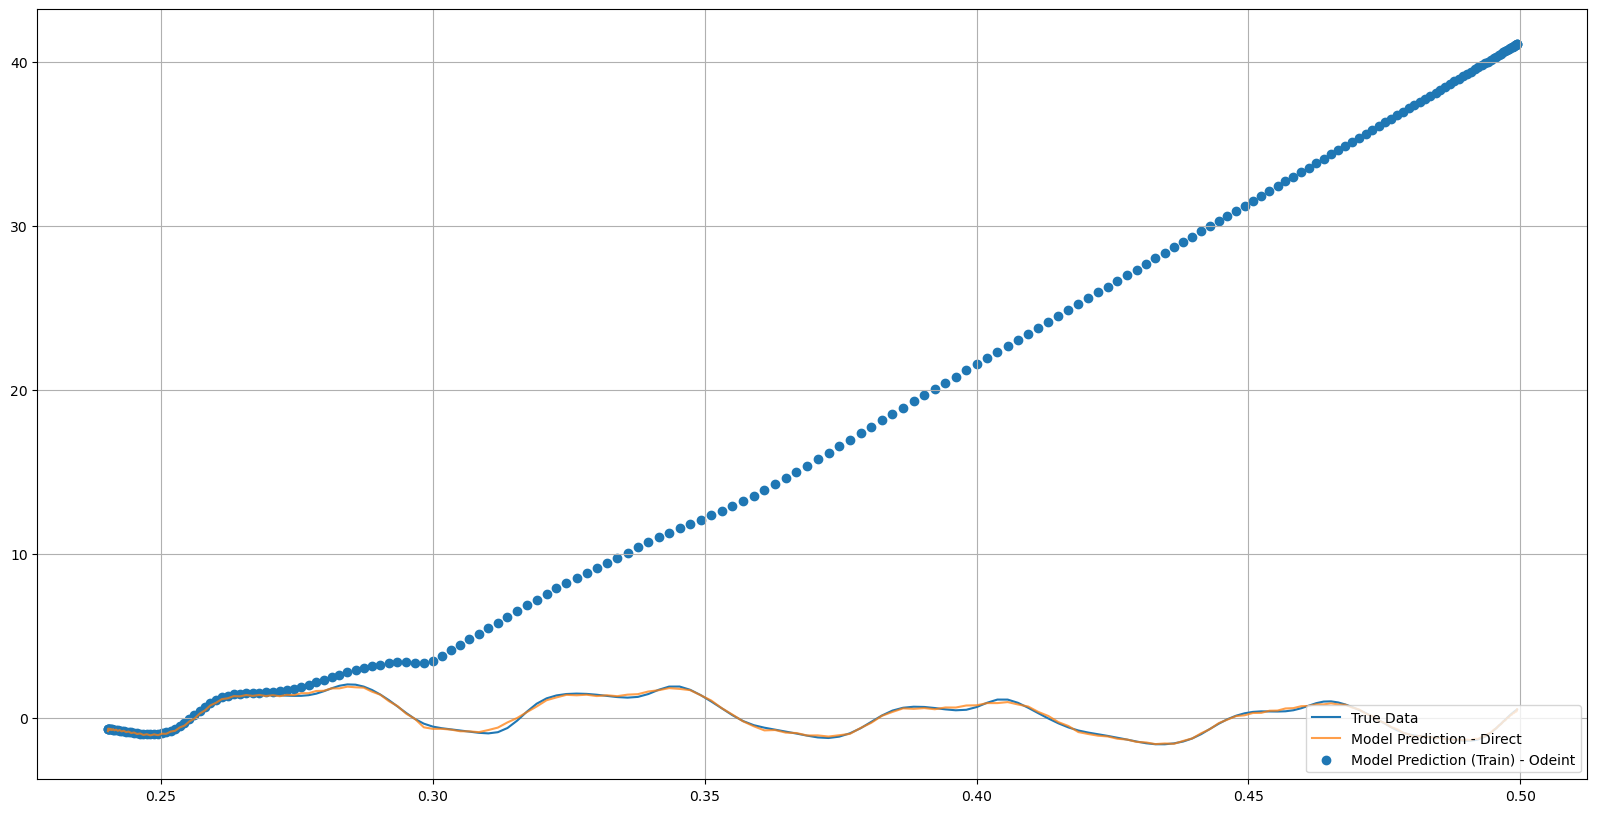

In [413]:
for i in range(1, 20, 5):
    file_path = 'df_train.csv'
    start_date = f'2011-01-{i:02d}'
    number_of_points = 800

    data_subsample = load_data(file_path, start_date, number_of_points)
    df_train, df_test = preprocessing(data_subsample, 48, 4, sigma = 2, split = 400)

    layer_widths = [7, 90, 1]

    ys = np.atleast_2d(df_train['y']).T
    ts = np.array(df_train['t'])
    Xs = np.array(df_train.drop(columns=['y', 't']))
    
    if len(ts) != len(Ds):
        weights = compute_weights(ts)
        Ds = np.array(lagrange_derivative(ts, weights))

    import nn_pyomo_base
    importlib.reload(nn_pyomo_base)
    NeuralODEPyomo_base = nn_pyomo_base.NeuralODEPyomo
    # ----------------------------------------------------------- #

    # solver.options['print_level'] = 5
    tol = 1e-8
    params = {"tol":1e-8, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            
            # repeat the same for the acceptable tolerances
            "acceptable_tol": 1e-15,
            "acceptable_constr_viol_tol": 1e-15,
            "acceptable_dual_inf_tol": 1e-15,
            "acceptable_compl_inf_tol": 1e-15,
            "acceptable_iter": 0, 
            
            "halt_on_ampl_error" : 'yes',
            "print_level": 1, 
            #"hessian_approximation": 'limited-memory', 
            #"mu_strategy": 'adaptive', 
            #"check_derivatives_for_naninf": 'yes',
            #'nlp_scaling_method' = 'gradient-based',
            # 'linear_solver'] = 'ma57',
            "max_iter": 1000}

    start_timer_build = time.time()
    ode_model = NeuralODEPyomo_base(np.array(ys), # y
                            np.array(ts), # t
                            np.array(Ds),
                            
                            layer_widths, act_func = "tanh", 
                            y_init = ys, 
                            penalty_lambda_reg = 0.001, 
                            time_invariant = True,
                            extra_input = Xs, # X
                            w_init_method = 'xavier', 
                            params = params,
                            # deriv_method="collocation"
                            # discretization_scheme = "LAGRANGE-RADAU",
                            )

    ode_model.build_model()
    end_timer_build = time.time()
    result = ode_model.solve_model()
    u_model = ode_model.extract_solution().T

    y0 = ys[0]
    y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

    print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
    print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")

    plt.figure(figsize=(20, 10))
    plt.plot(ts, ys, label='True Data', alpha = 1)

    plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
    plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')

    plt.legend(loc ="lower right")
    plt.grid(True)
    plt.show()

In [492]:
for i in range(4, 5):
    file_path = 'df_train.csv'
    start_date = f'2011-01-{i:02d}'
    number_of_points = 800

    data_subsample = load_data(file_path, start_date, number_of_points)
    df_train, df_test = preprocessing(data_subsample, 48, 2, sigma = 2, split = 300, num_nodes_mult = 1, equally_spaced = True)

    layer_widths = [5, 64, 1]

    ys = np.atleast_2d(df_train['y']).T
    ts = np.array(df_train['t'])
    Xs = np.array(df_train.drop(columns=['y', 't']))
    
    if len(ts) != len(Ds):
        weights = compute_weights(ts)
        Ds = np.array(lagrange_derivative(ts, weights))

    import nn_pyomo_constraints
    importlib.reload(nn_pyomo_constraints)
    NeuralODEPyomo = nn_pyomo_constraints.NeuralODEPyomo
    # ----------------------------------------------------------- #

    # solver.options['print_level'] = 5
    tol = 1e-6
    params = {"tol":1e-6, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            
            # repeat the same for the acceptable tolerances
            "acceptable_tol": 1e-15,
            "acceptable_constr_viol_tol": 1e-15,
            "acceptable_dual_inf_tol": 1e-15,
            "acceptable_compl_inf_tol": 1e-15,
            "acceptable_iter": 0, 
            
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            #"hessian_approximation": 'limited-memory', 
            #"mu_strategy": 'adaptive', 
            #"check_derivatives_for_naninf": 'yes',
            #'nlp_scaling_method' = 'gradient-based',
            # 'linear_solver'] = 'ma57',
            "max_iter": 1000}

    start_timer_build = time.time()
    ode_model = NeuralODEPyomo(np.array(ys), # y
                            np.array(ts), # t
                            np.array(Ds),
                            
                            layer_widths, act_func = "tanh", 
                            y_init = ys, 
                            penalty_lambda_reg = 0.01, 
                            time_invariant = True,
                            extra_input = Xs, # X
                            w_init_method = 'xavier', 
                            params = params,
                            deriv_method="collocation",
                            penalty_lambda_smooth = 1,
                            ncp = 3
                            
                            #discretization_scheme = "LAGRANGE-RADAU",
                            )

    ode_model.build_model()
    end_timer_build = time.time()
    result = ode_model.solve_model()
    u_model = ode_model.extract_solution().T

    y0 = ys[0]
    y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

    print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
    print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")

    plt.figure(figsize=(20, 10))
    plt.plot(ts, ys, label='True Data', alpha = 1)

    plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
    plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')
    plt.plot(ts[1:], ode_model.extract_derivative()[1:]*0.05, label='Derivative', alpha = 0.75)

    plt.legend(loc ="lower right")
    plt.grid(True)
    plt.show()

The first/ last time points in the subsample are 2011-01-04 00:00:00/ 2011-01-20 15:30:00
Covering 16 days
Number of points per day: 48
Time offset needed for 1 day: 0.06
Training data: 204 timepoints
Training data: 500 timepoints
Training data: 204 timepoints after interpolation
<class 'pyomo.core.expr.numeric_expr.LinearExpression'>
<class 'pyomo.core.expr.numeric_expr.LinearExpression'>
<class 'pyomo.core.expr.numeric_expr.LinearExpression'>
<class 'pyomo.core.expr.numeric_expr.LinearExpression'>
<class 'pyomo.core.expr.numeric_expr.LinearExpression'>
<class 'pyomo.core.expr.numeric_expr.LinearExpression'>
<class 'pyomo.core.expr.numeric_expr.LinearExpression'>
<class 'pyomo.core.expr.numeric_expr.LinearExpression'>
<class 'pyomo.core.expr.numeric_expr.LinearExpression'>
<class 'pyomo.core.expr.numeric_expr.LinearExpression'>
<class 'pyomo.core.expr.numeric_expr.LinearExpression'>
<class 'pyomo.core.expr.numeric_expr.LinearExpression'>
<class 'pyomo.core.expr.numeric_expr.LinearExpr

TypeError: Cannot create an EqualityExpression where one of the sub-expressions is a relational expression:
    sign_change[0]
    {==}
    (-113579.48573320199*y[0.12015018773466835] + 131474.56019102843*y[0.12016539980304944] - 32870.608145895196*y[0.120211032364957] + 14610.61716609895*y[0.12028707449155643] - 8219.62048818083*y[0.12039350797103165] + 5261.502206908786*y[0.12053030731294678] - 3654.623332703307*y[0.12069743975435099] + 2685.7262526233726*y[0.12089486526762516] - 2056.8749888800003*y[0.12112253657006827] + 1625.7368441728256*y[0.12138039913522153] - 1317.3464807999283*y[0.1216683912059271] + 1089.172707352039*y[0.12198644380911897] - 915.6280615771428*y[0.12233448077234152] + 780.5697434321464*y[0.1227124187419927] - 673.4053286002152*y[0.12312016720328686] + 586.9507752607387*y[0.1235576285019327] - 516.1942881610611*y[0.12402469786752117] + 457.5532741731756*y[0.12452126343861757] - 408.41176678946425*y[0.1250472062895519] + 366.82354507401277*y[0.12560240045890136] - 331.3164310314258*y[0.12618671297965733] + 300.7601935070122*y[0.1268000039110708] - 274.2754841237683*y[0.12744212637216742] + 251.16985997169047*y[0.1281129265769252] - 230.89206171127935*y[0.12881224387110551] + 212.99882779502036*y[0.12953991077072927] - 197.1304651110456*y[0.13029575300218882] + 182.99263170064455*y[0.1310795895439858] - 170.3425896930115*y[0.13189123267008496] + 158.9787174100545*y[0.1327304879948742] - 148.73242657402773*y[0.13359715451971896] + 139.46187432934138*y[0.1344910246811008] - 131.04702863745715*y[0.1354118844003281] + 123.38576409748538*y[0.13635951313480707] - 116.39074942409597*y[0.13733368393086098] + 109.98694830117651*y[0.13833416347808472] - 104.10959925799631*y[0.13936071216522183] + 98.70257243758343*y[0.14041308413755058] - 93.71702498638396*y[0.1414910273557651] + 89.1102946173844*y[0.14259428365633806] - 84.8449843240478*y[0.14372258881334987] + 80.88820141448635*y[0.14487567260176987] - 77.21092183070148*y[0.14605325886217418] + 73.78745672204244*y[0.14725506556688495] - 70.59500289777306*y[0.14848080488751494] + 67.61326241663191*y[0.14973018326390136] - 64.82411942338797*y[0.15100290147441264] + 62.21136459428095*y[0.15229865470761061] - 59.76045934106423*y[0.153617132635252] + 57.458333350203254*y[0.15495801948661103] - 55.29321017805422*y[0.15632099412410505] + 53.254456545166754*y[0.1577057301202061] - 51.33245171948862*y[0.15911189583561894] + 49.5184739853671*y[0.16053915449870756] - 47.804601691037824*y[0.16198716428615084] + 46.18362677374364*y[0.163455578404808] - 44.64897899617304*y[0.16494404517477407] + 43.194659404335894*y[0.1664522081136064] - 41.81518174610517*y[0.16797970602170031] + 40.50552078033217*y[0.16952617306879586] - 39.26106656559755*y[0.17109123888159222] + 38.077583950896894*y[0.17267452863245109] - 36.951176602582606*y[0.17427566312916654] + 35.87825499615315*y[0.17589425890577998] - 34.85550788123783*y[0.17752992831441922] + 33.87987679564116*y[0.17918227961813835] - 32.94853326171189*y[0.18085091708473772] + 32.05885834718994*y[0.18253544108154007] - 31.208424314428843*y[0.18423544817110132] + 30.394978117653153*y[0.18595053120783228] - 29.61642653857119*y[0.18768027943550852] + 28.870822777065474*y[0.18942427858564517] - 28.15635433642706*y[0.19118211097671264] + 27.471332062241377*y[0.19295335561416974] - 26.814180211074316*y[0.1947375882912906] + 26.183427439851094*y[0.19653438169076043] - 25.57769861965651*y[0.1983433054870166] + 24.995707388872137*y[0.20016392644931] - 24.43624937031533*y[0.20199580854546242] + 23.898195985563973*y[0.20383851304629438] - 23.38048880713151*y[0.20569159863069947] + 22.88213439570813*y[0.20755462149133905] - 22.402199575429048*y[0.2094271354409325] + 21.93980710521641*y[0.21130869201911762] - 21.494131708694102*y[0.21319884059985494] + 21.06439642913521*y[0.21509712849935148] - 20.649869279382877*y[0.21700310108447646] + 20.249860159778027*y[0.21891630188164468] - 19.863718019872024*y[0.22083627268614] + 19.49082824213583*y[0.22276255367185402] - 19.130610228043306*y[0.2246946835014124] + 18.782515168835968*y[0.2266321994366638] - 18.446023985005432*y[0.22857463744950401] + 18.12064542005146*y[0.23052153233300882] - 17.805914275462168*y[0.23247241781284958] + 17.501389775086075*y[0.23442682665896405] - 17.206654048171373*y[0.23638429079745654] + 16.921310721339076*y[0.23834434142269975] - 16.644983610641177*y[0.24030650910961218] + 16.377315505659023*y[0.24227032392608353] - 16.11796703831814*y[0.24423531554552205] + 15.86661562974281*y[0.24620101335949576] - 15.622954509058683*y[0.2481669465904417] + 15.386691798589258*y[0.2501326444044154] - 15.157549660357985*y[0.2520976360238539] + 14.935263499253235*y[0.2540614508403253] - 14.719581218598469*y[0.2560236185272377] + 14.51026252422903*y[0.25798366915248094] - 14.30707827350208*y[0.2599411332909734] + 14.109809865957494*y[0.2618955421370879] - 13.918248672614052*y[0.2638464276169286] + 13.7321955011299*y[0.2657933225004334] - 13.551460094281058*y[0.26773576051327364] + 13.375860659408254*y[0.26967327644852507] - 13.205223426669736*y[0.27160540627808344] + 13.039382234107917*y[0.27353168726379745] - 12.878178137686067*y[0.27545165806829275] + 12.721459044601774*y[0.277364858865461] - 12.569079368303603*y[0.279270831450586] + 12.420899703755651*y[0.2811691193500825] - 12.276786521615511*y[0.2830592679308198] + 12.136611880077039*y[0.28494082450900493] - 12.000253153222982*y[0.2868133384585984] + 11.867592774823619*y[0.28867636131923796] - 11.738517996591176*y[0.2905294469036431] + 11.612920659965367*y[0.29237215140447503] - 11.490696980577901*y[0.2942040335006274] + 11.371747344605245*y[0.29602465446292087] - 11.255976116265007*y[0.297833578259177] + 11.143291455774197*y[0.29963037165864687] - 11.03360514712738*y[0.3014146043357677] + 10.926832435097538*y[0.3031858489732248] - 10.822891870909139*y[0.30494368136429223] + 10.72170516606148*y[0.3066876805144289] - 10.623197053819284*y[0.30841742874210515] + 10.527295157921703*y[0.3101325117788361] - 10.433929868087745*y[0.31183251886839736] + 10.343034221923888*y[0.3135170428651997] - 10.254543792868104*y[0.3151856803317991] + 10.16839658382309*y[0.31683803163551827] - 10.084532926158344*y[0.31847370104415745] + 10.002895383781393*y[0.3200922968207709] - 9.92342866199352*y[0.32169343131748634] + 9.846079520864436*y[0.3232767210683452] - 9.77079669288097*y[0.32484178688114157] + 9.697530804636854*y[0.3263882539282371] - 9.62623430234227*y[0.3279157518363311] + 9.5568613809506*y[0.3294239147751633] - 9.48936791671196*y[0.3309123815451294] + 9.4237114029697*y[0.3323807956637866] - 9.359850889029046*y[0.3338288054512299] + 9.297746921943322*y[0.3352560641143185] - 9.237361491065291*y[0.3366622298297314] + 9.178657975218716*y[0.3380469658258324] - 9.121601092362905*y[0.3394099404633264] + 9.06615685162369*y[0.3407508273146854] - 9.012292507570653*y[0.34206930524232687] + 8.959976516631237*y[0.3433650584755248] - 8.9091784955386*y[0.344637776686036] + 8.85986918171435*y[0.3458871550624225] - 8.812020395488846*y[0.3471128943830525] + 8.765605004077816*y[0.34831470108776325] - 8.72059688723287*y[0.3494922873481676] + 8.676970904478756*y[0.35064537113658756] - 8.63470286387643*y[0.3517736762935994] + 8.593769492235424*y[0.35287693259417235] - 8.554148406707718*y[0.3539548758123868] + 8.515818087710999*y[0.3550072477847156] - 8.47875785311279*y[0.35603379647185274] + 8.442947833624602*y[0.35703427601907645] - 8.40836894935978*y[0.3580084468151304] + 8.375002887495137*y[0.35895607554960934] - 8.342832080996217*y[0.35987693526883663] + 8.311839688365833*y[0.3607708054302185] - 8.282009574366167*y[0.36163747195506324] + 8.253326291683397*y[0.3624767272798525] - 8.225775063494442*y[0.36328837040595163] + 8.199341766901409*y[0.3640722069477486] - 8.174012917201429*y[0.3648280491792082] + 8.149775652959312*y[0.3655557160788319] - 8.126617721862331*y[0.36625503337301224] + 8.104527467319233*y[0.36692583357777003] - 8.083493815779779*y[0.36756795603886666] + 8.063506264758548*y[0.3681812469702801] - 8.044554871534087*y[0.36876555949103607] + 8.02663024250295*y[0.3693207536603855] - 8.009723523166416*y[0.36984669651131985] + 7.993826388738847*y[0.37034326208241625] - 7.978931035355084*y[0.37081033144800474] + 7.965030171854716*y[0.37124779274665054] - 7.9521170121473*y[0.37165554120794475] + 7.9401852681206755*y[0.3720334791775959] - 7.929229143099229*y[0.3723815161408185] + 7.919243325829641*y[0.37269956874401033] - 7.910222984984058*y[0.37298756081471596] + 7.902163764175985*y[0.37324542337986916] - 7.895061777474444*y[0.37347309468231227] + 7.8889136054186055*y[0.37367052019558644] - 7.883716291505036*y[0.37383765263699065] + 7.879467339165831*y[0.3739744519789058] - 7.8761647092252325*y[0.37408088545838103] + 7.873806817798047*y[0.3741569275849804] - 7.8723925347031205*y[0.374202560146888] + 3.935960591141284*y[0.3742177722152691])*(-32868.64004775535*y[0.12015018773466835] + 21609.66616718695*y[0.12016539980304944] + 21914.176153987955*y[0.120211032364957] - 8218.636203394472*y[0.12028707449155643] + 4383.885105238163*y[0.12039350797103165] - 2740.4204432019237*y[0.12053030731294678] + 1879.5581000152952*y[0.12069743975435099] - 1370.8668176389463*y[0.12089486526762516] + 1044.7827671639832*y[0.12112253657006827] - 823.0457198792246*y[0.12138039913522153] + 665.3398004045987*y[0.1216683912059271] - 549.1355489859029*y[0.12198644380911897] + 461.0247446534512*y[0.12233448077234152] - 392.6158477704121*y[0.1227124187419927] + 338.4361151135256*y[0.12312016720328686] - 294.7914450253922*y[0.1235576285019327] + 259.11447711340384*y[0.12402469786752117] - 229.57559824297326*y[0.12452126343861757] + 204.84220395979023*y[0.1250472062895519] - 183.92493643054036*y[0.12560240045890136] + 166.07672955548713*y[0.12618671297965733] - 150.72489386237615*y[0.1268000039110708] + 137.42442985893575*y[0.12744212637216742] - 125.82530747646688*y[0.1281129265769252] + 115.64913072674325*y[0.12881224387110551] - 106.67223105803342*y[0.12953991077072927] + 98.71324131969239*y[0.13029575300218882] - 91.62384233156767*y[0.1310795895439858] + 85.28178862344903*y[0.13189123267008496] - 79.5855934104032*y[0.1327304879948742] + 74.45043637964778*y[0.13359715451971896] - 69.8049829248682*y[0.1344910246811008] + 65.58888992541348*y[0.1354118844003281] - 61.75083374520792*y[0.13635951313480707] + 58.246939097455744*y[0.13733368393086098] - 55.039518257068394*y[0.13833416347808472] + 52.09605247013733*y[0.13936071216522183] - 49.38836379903377*y[0.14041308413755058] + 46.89193776494513*y[0.1414910273557651] - 44.58536619751413*y[0.14259428365633806] + 42.4498865107875*y[0.14372258881334987] - 40.46899879034226*y[0.14487567260176987] + 38.628146024612185*y[0.14605325886217418] - 36.91444585246343*y[0.14725506556688495] + 35.31646455409705*y[0.14848080488751494] - 33.82402584901507*y[0.14973018326390136] + 32.42804850592038*y[0.15100290147441264] - 31.120407906716082*y[0.15229865470761061] + 29.89381760928686*y[0.153617132635252] - 28.741727673725517*y[0.15495801948661103] + 27.658237093838263*y[0.15632099412410505] - 26.638018140808633*y[0.1577057301202061] + 25.67625080223232*y[0.15911189583561894] - 24.76856580564655*y[0.16053915449870756] + 23.910994965420226*y[0.16198716428615084] - 23.099927796550958*y[0.163455578404808] + 22.332073507338517*y[0.16494404517477407] - 21.60442762203417*y[0.1664522081136064] + 20.91424259985091*y[0.16797970602170031] - 20.25900191264539*y[0.16952617306879586] + 19.63639712363148*y[0.17109123888159222] - 19.044307576484947*y[0.17267452863245109] + 18.480782360519946*y[0.17427566312916654] - 17.944024265004245*y[0.17589425890577998] + 17.432375475764875*y[0.17752992831441922] - 16.944304801162467*y[0.17918227961813835] + 16.478396243351906*y[0.18085091708473772] - 16.033338755305575*y[0.18253544108154007] + 15.607917045042477*y[0.18423544817110132] - 15.201003306466129*y[0.18595053120783228] + 14.811549771610025*y[0.18768027943550852] - 14.43858199234534*y[0.18942427858564517] + 14.081192771023037*y[0.19118211097671264] - 13.738536669381785*y[0.19295335561416974] + 13.40982503360598*y[0.1947375882912906] - 13.094321480817255*y[0.19653438169076043] + 12.791337798724033*y[0.1983433054870166] - 12.50023021576665*y[0.20016392644931] + 12.220396003986803*y[0.20199580854546242] - 11.951270381123786*y[0.20383851304629438] + 11.6923236821923*y[0.20569159863069947] - 11.443058774082543*y[0.20755462149133905] + 11.203008689604786*y[0.2094271354409325] - 10.971734459950829*y[0.21130869201911762] + 10.748823126777754*y[0.21319884059985494] - 10.533885917105172*y[0.21509712849935148] + 10.326556565962552*y[0.21700310108447646] - 10.126489773273686*y[0.21891630188164468] + 9.933359782841391*y[0.22083627268614] - 9.746859072515345*y[0.22276255367185402] + 9.566697145711773*y[0.2246946835014124] - 9.392599415420921*y[0.2266321994366638] + 9.224306172704777*y[0.22857463744950401] - 9.061571632450185*y[0.23052153233300882] + 8.904163049838326*y[0.23247241781284958] - 8.751859901604629*y[0.23442682665896405] + 8.604453126717097*y[0.23638429079745654] - 8.46174442159786*y[0.23834434142269975] + 8.32354558545586*y[0.24030650910961218] - 8.189677911701507*y[0.24227032392608353] + 8.059971621775368*y[0.24423531554552205] - 7.934265338047084*y[0.24620101335949576] + 7.81240559273391*y[0.2481669465904417] - 7.694246370057334*y[0.2501326444044154] + 7.579648679089897*y[0.2520976360238539] - 7.468480154967278*y[0.2540614508403253] + 7.360614686333688*y[0.2560236185272377] - 7.255932067068513*y[0.25798366915248094] + 7.154317670504881*y[0.2599411332909734] - 7.055662144496836*y[0.2618955421370879] + 6.959861125825173*y[0.2638464276169286] - 6.866814972554603*y[0.2657933225004334] + 6.776428513067469*y[0.26773576051327364] - 6.68861081059757*y[0.26967327644852507] + 6.603274942181644*y[0.27160540627808344] - 6.520337791031085*y[0.27353168726379745] + 6.439719851400968*y[0.27545165806829275] - 6.361345045108644*y[0.277364858865461] + 6.285140548914256*y[0.279270831450586] - 6.2110366320346015*y[0.2811691193500825] + 6.138966503122399*y[0.2830592679308198] - 6.068866166085911*y[0.28494082450900493] + 6.0006742841708425*y[0.2868133384585984] - 5.934332051771956*y[0.28867636131923796] + 5.8697830734788266*y[0.2905294469036431] - 5.80697324989287*y[0.29237215140447503] + 5.745850669789123*y[0.2942040335006274] - 5.686365508227037*y[0.29602465446292087] + 5.628469930237601*y[0.297833578259177] - 5.572117999745527*y[0.29963037165864687] + 5.517265593405259*y[0.3014146043357677] - 5.4638703190518845*y[0.3031858489732248] + 5.411891438491445*y[0.30494368136429223] - 5.36128979436944*y[0.3066876805144289] + 5.312027740875796*y[0.30841742874210515] - 5.264069078061646*y[0.3101325117788361] + 5.217378989556777*y[0.31183251886839736] - 5.171923983490427*y[0.3135170428651997] + 5.127671836432388*y[0.3151856803317991] - 5.084591540180673*y[0.31683803163551827] + 5.042653251235417*y[0.31847370104415745] - 5.001828242809065*y[0.3200922968207709] + 4.962088859230359*y[0.32169343131748634] - 4.92340847260929*y[0.3232767210683452] + 4.885761441640421*y[0.32484178688114157] - 4.849123072428028*y[0.3263882539282371] + 4.813469581222331*y[0.3279157518363311] - 4.778778058965422*y[0.3294239147751633] + 4.745026437551639*y[0.3309123815451294] - 4.712193457710383*y[0.3323807956637866] + 4.6802586384259355*y[0.3338288054512299] - 4.649202247816888*y[0.3352560641143185] + 4.619005275398953*y[0.3366622298297314] - 4.589649405658624*y[0.3380469658258324] + 4.561116992874014*y[0.3394099404633264] - 4.533391037119588*y[0.3407508273146854] + 4.506455161394615*y[0.34206930524232687] - 4.480293589820651*y[0.3433650584755248] + 4.454891126856432*y[0.344637776686036] - 4.43023313748072*y[0.3458871550624225] + 4.406305528294395*y[0.3471128943830525] - 4.383094729501187*y[0.34831470108776325] + 4.360587677725744*y[0.3494922873481676] - 4.338771799625493*y[0.35064537113658756] + 4.317634996265779*y[0.3517736762935994] - 4.29716562822*y[0.35287693259417235] + 4.277352501360836*y[0.3539548758123868] - 4.258184853316485*y[0.3550072477847156] + 4.239652340557627*y[0.35603379647185274] - 4.221745026089682*y[0.35703427601907645] + 4.204453367727183*y[0.3580084468151304] - 4.187768206920302*y[0.35895607554960934] + 4.171680758113403*y[0.35987693526883663] - 4.156182598615488*y[0.3607708054302185] + 4.141265658957616*y[0.36163747195506324] - 4.126922213721798*y[0.3624767272798525] + 4.113144872821142*y[0.36328837040595163] - 4.099926573214029*y[0.3640722069477486] + 4.087260571036159*y[0.3648280491792082] - 4.07514043413417*y[0.3655557160788319] + 4.063560034990481*y[0.36625503337301224] - 4.052513544020398*y[0.36692583357777003] + 4.041995423229628*y[0.36756795603886666] - 4.032000420224059*y[0.3681812469702801] + 4.02252356255735*y[0.36876555949103607] - 4.013560152406083*y[0.3693207536603855] + 4.005105761561382*y[0.36984669651131985] - 3.997156226731461*y[0.37034326208241625] + 3.9897076451438105*y[0.37081033144800474] - 3.982756370435916*y[0.37124779274665054] + 3.976299008836569*y[0.37165554120794475] - 3.97033241561881*y[0.3720334791775959] + 3.964853691827953*y[0.3723815161408185] - 3.9598601812734455*y[0.37269956874401033] + 3.955349467779523*y[0.37298756081471596] - 3.9513193726923217*y[0.37324542337986916] + 3.947767952636199*y[0.37347309468231227] - 3.944693497520394*y[0.37367052019558644] + 3.9420945287820572*y[0.37383765263699065] - 3.9399697978748116*y[0.3739744519789058] + 3.938318284996646*y[0.37408088545838103] - 3.9371391980387718*y[0.3741569275849804] + 3.9364319717920933*y[0.374202560146888] - 1.968098133678317*y[0.3742177722152691])  <=  0

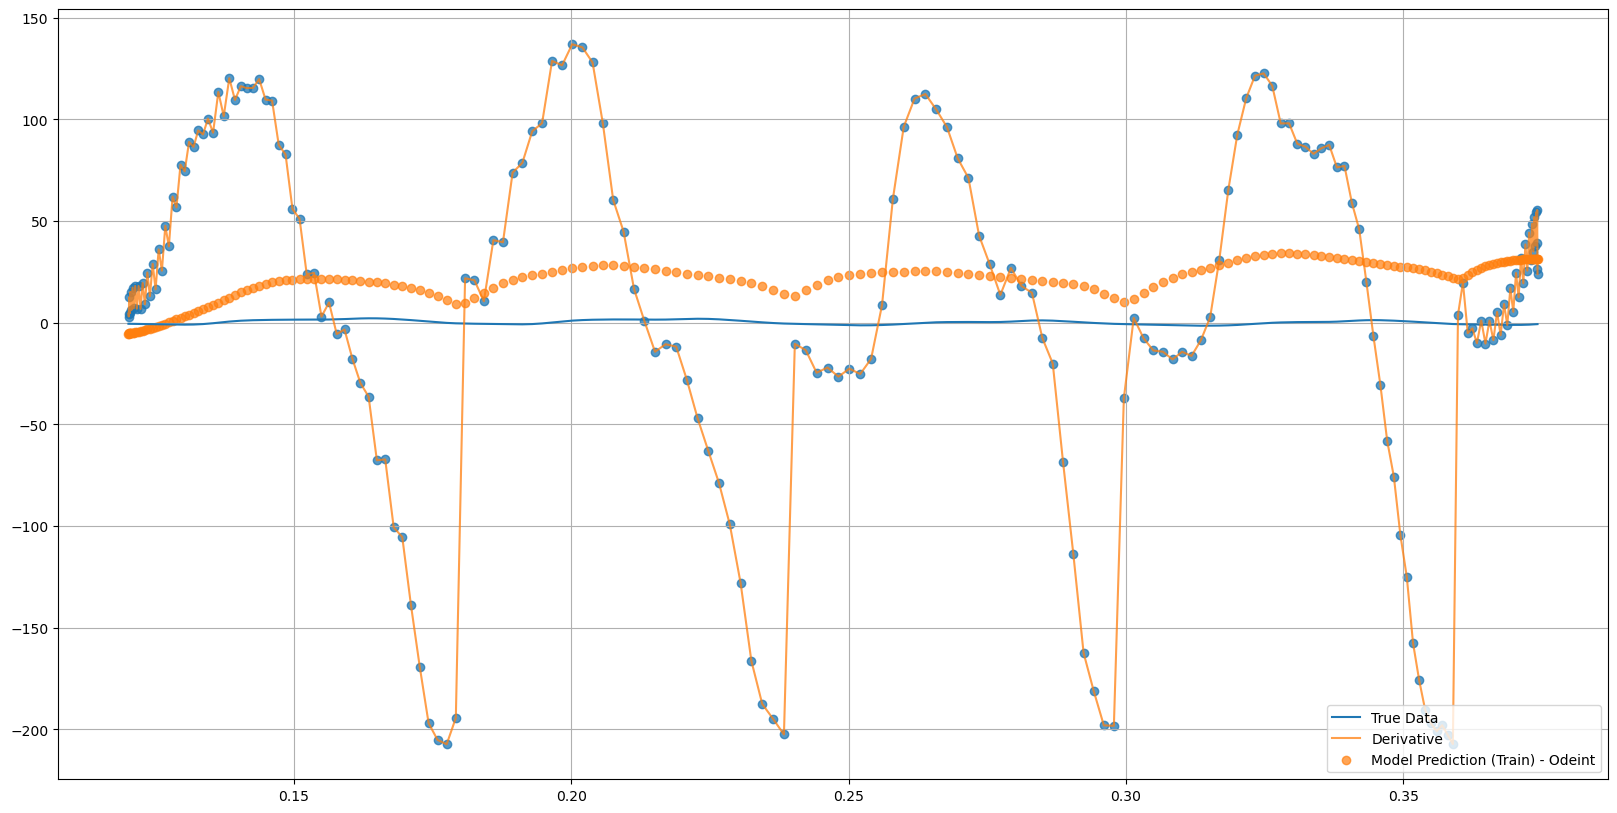

In [489]:
len(ode_model.extract_derivative())

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(ts[1:], ode_model.extract_derivative()[1:], label='Derivative', alpha = 0.75)
plt.scatter(ts[1:], ode_model.extract_derivative()[1:], alpha = 0.75)
plt.scatter(ts, y_pred*10, label='Model Prediction (Train) - Odeint', alpha = 0.7)

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

Ipopt 3.14.16: tol=1e-08
dual_inf_tol=1e-05
compl_inf_tol=1e-05
constr_viol_tol=1e-05
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     1012
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      203

Total number of variables............................:      406
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
 

{'solver_time': 0.08951616287231445, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
203


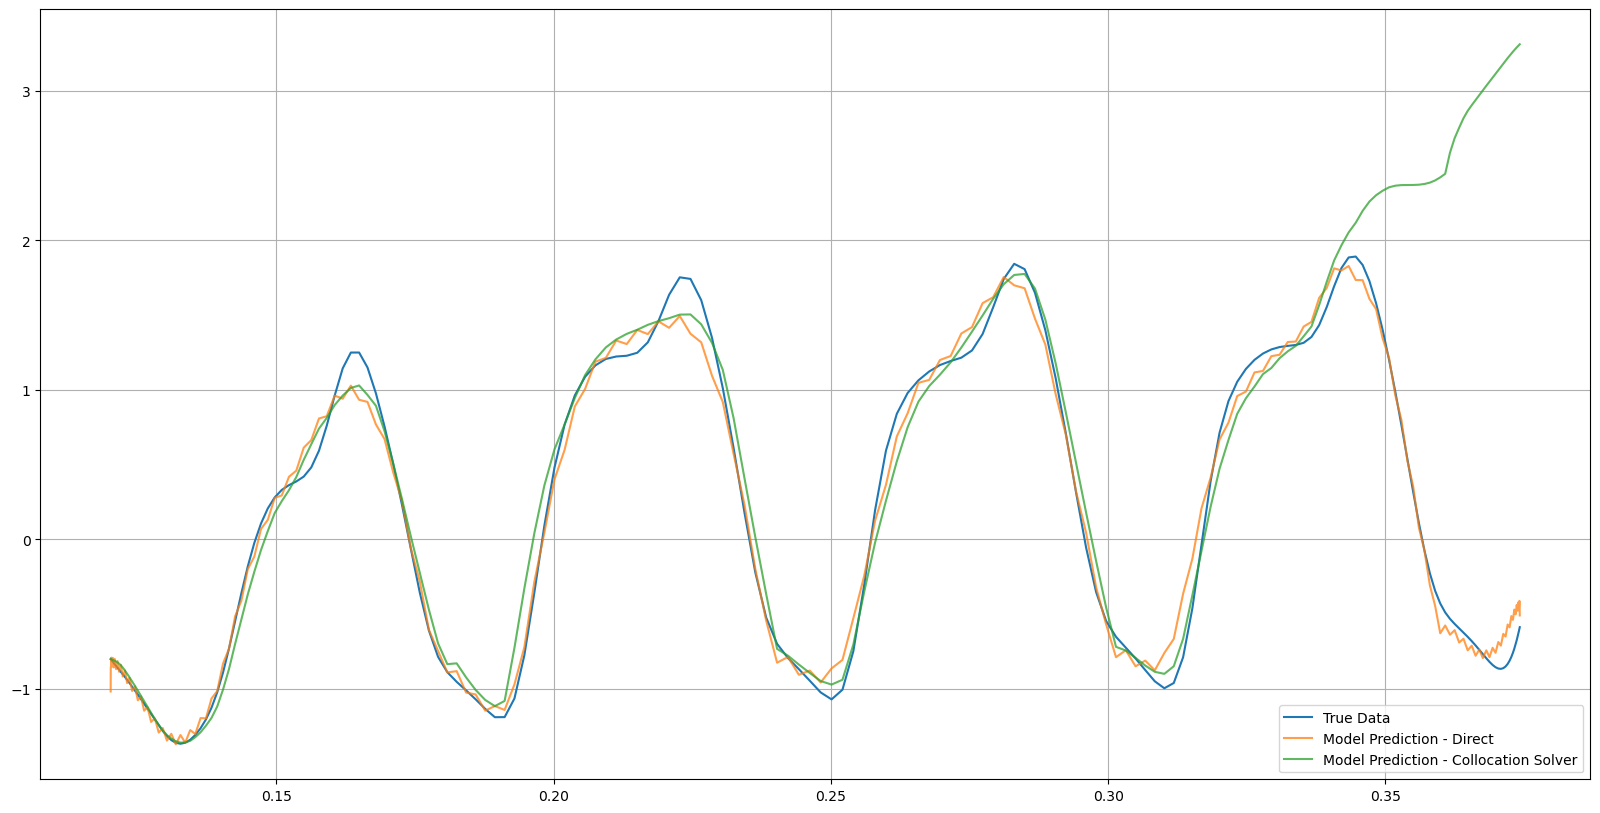

In [456]:
trained_weights_biases = ode_model.extract_weights()

W1 = trained_weights_biases['W1']
b1 = trained_weights_biases['b1']
W2 = trained_weights_biases['W2']
b2 = trained_weights_biases['b2']

trained_weights = [W1, W2]
trained_biases = [b1, b2]

import ode_solver_pyomo
importlib.reload(ode_solver_pyomo)
DirectODESolver = ode_solver_pyomo.DirectODESolver

# Define the layer sizes as per your neural network architecture
layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]

tol = 1e-5
params = {"tol":1e-8, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            "acceptable_iter": 0,  
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 100 }

initial_state = (ys[0])
# Initialize the direct ODE solver
direct_solver = DirectODESolver(np.array(ts)[1:], layer_sizes, trained_weights, trained_biases, initial_state, 
                                time_invariant=True, extra_input=np.array(Xs), 
                                params=params,
                                #discretization_scheme = "LAGRANGE-LEGENDRE"
                                )
# LAGRANGE-LEGENDRE

# Build and solve the model
direct_solver.build_model()
solver_info = direct_solver.solve_model()

# Extract the solution
t_solution, y_solution = direct_solver.extract_solution()
print(len(y_solution))

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.plot(t_solution, y_solution, label='Model Prediction - Collocation Solver', alpha = 0.75)
#plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()


---

In [372]:
trained_weights_biases = ode_model.extract_weights()

W1 = trained_weights_biases['W1']
b1 = trained_weights_biases['b1']
W2 = trained_weights_biases['W2']
b2 = trained_weights_biases['b2']

trained_weights = [W1, W2]
trained_biases = [b1, b2]

import ode_solver_pyomo
importlib.reload(ode_solver_pyomo)
DirectODESolver = ode_solver_pyomo.DirectODESolver

# Define the layer sizes as per your neural network architecture
layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]

tol = 1e-5
params = {"tol":1e-8, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            "acceptable_iter": 0,  
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 100 }

initial_state = (u_model[0])
# Initialize the direct ODE solver
direct_solver = DirectODESolver(np.array(ts), layer_sizes, trained_weights, trained_biases, initial_state, 
                                time_invariant=True, extra_input=np.array(Xs), 
                                #params=params,
                                #discretization_scheme = "LAGRANGE-LEGENDRE"
                                )
# LAGRANGE-LEGENDRE

# Build and solve the model
direct_solver.build_model()
solver_info = direct_solver.solve_model()

# Extract the solution
t_solution, y_solution = direct_solver.extract_solution()
print(len(y_solution))


Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     9137
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1016

Total number of variables............................:     2032
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2031
Total number

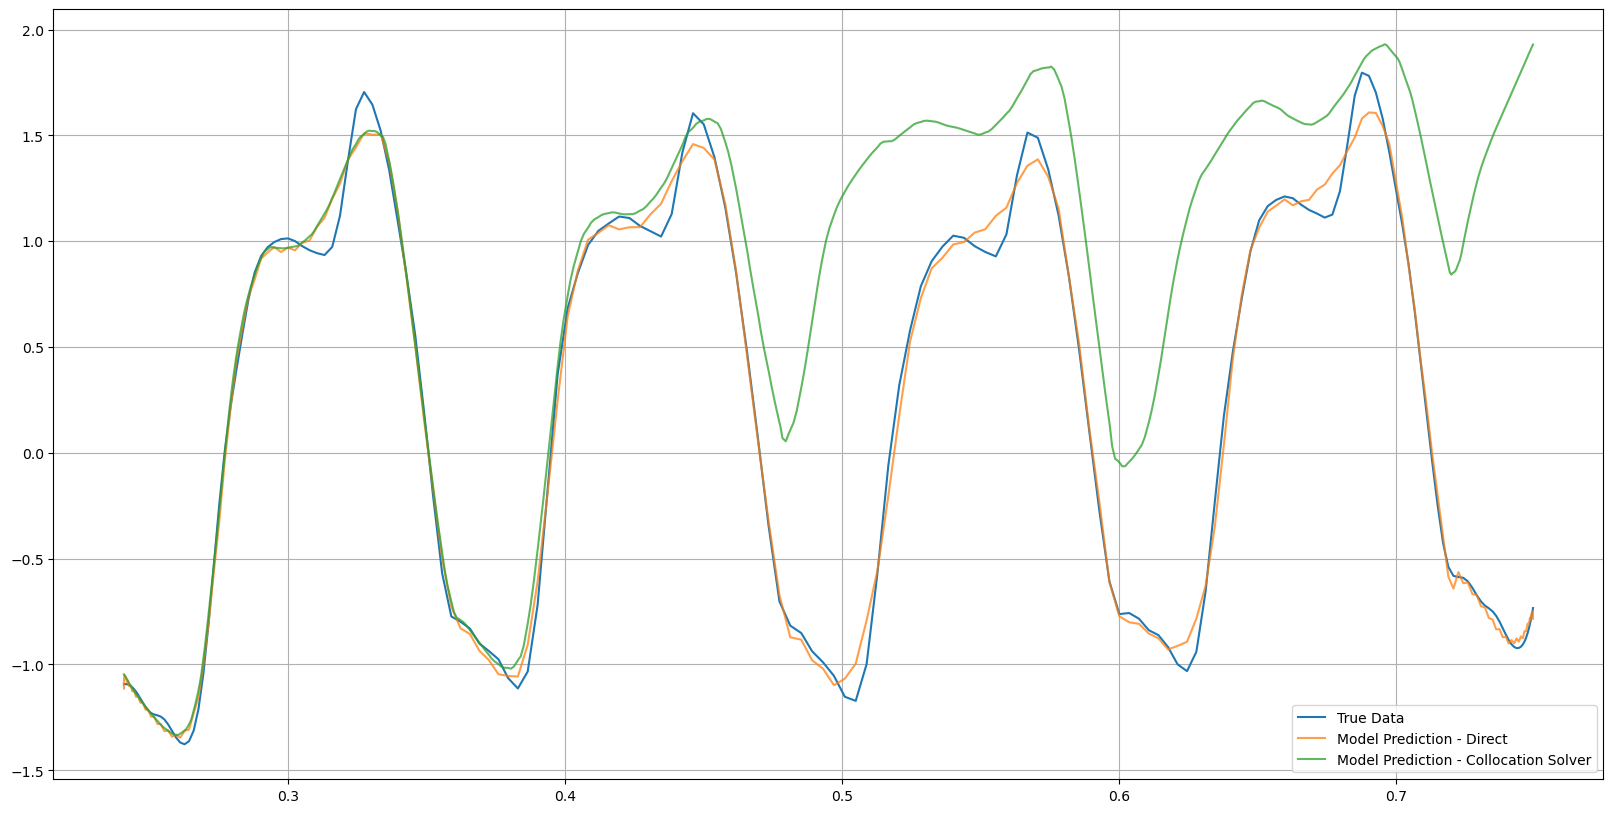

In [373]:
plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.plot(t_solution, y_solution, label='Model Prediction - Collocation Solver', alpha = 0.75)

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

----
----

In [343]:
layer_widths = [5, 70, 1]

ys = np.atleast_2d(df_train['y']).T
ts = np.array(df_train['t'])
Xs = np.array(df_train.drop(columns=['y', 't']))

import nn_pyomo
importlib.reload(nn_pyomo)
NeuralODEPyomo = nn_pyomo.NeuralODEPyomo
# ----------------------------------------------------------- #

# solver.options['print_level'] = 5
tol = 1e-5
params = {"tol":1e-5, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          "acceptable_tol": 1e-15,
          "acceptable_constr_viol_tol": 1e-15,
          "acceptable_dual_inf_tol": 1e-15,
          "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 1, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          #'nlp_scaling_method' = 'gradient-based',
          # 'linear_solver'] = 'ma57',
          "max_iter": 1000}

y0 = ys[0]
solver_time = 0
mae_train_direct, mae_train_ode, mae_train_coll = 0, 0, 0
for i in range(10):
    NeuralODEPyomo = nn_pyomo.NeuralODEPyomo
    ode_model = NeuralODEPyomo(np.array(ys), # y
                            np.array(ts), # t
                            np.array(Ds),
                            
                            layer_widths, act_func = "tanh", 
                            y_init = ys, 
                            penalty_lambda_reg = 0.001, 
                            time_invariant = True,
                            extra_input = Xs, # X
                            w_init_method = 'xavier', 
                            params = params,
                            deriv_method="collocation"
                            #discretization_scheme = "LAGRANGE-RADAU",
                            )

    ode_model.build_model()
    result = ode_model.solve_model()
    u_model = ode_model.extract_solution().T
    y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

    print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
    print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")
    solver_time += result['solver_time']
    
    mae_train_direct += np.mean(np.abs(ys.T - u_model))
    mae_train_ode += np.mean(np.abs(ys - y_pred))

    collocation_solver = False
    if collocation_solver:
        trained_weights_biases = ode_model.extract_weights()

        W1 = trained_weights_biases['W1']
        b1 = trained_weights_biases['b1']
        W2 = trained_weights_biases['W2']
        b2 = trained_weights_biases['b2']

        trained_weights = [W1, W2]
        trained_biases = [b1, b2]

        layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]

        tol = 1e-3
        params = {"tol":1e-3, 
                    "dual_inf_tol": tol, 
                    "compl_inf_tol": tol,
                    "constr_viol_tol": tol, 
                    "acceptable_iter": 0,  
                    "halt_on_ampl_error" : 'yes',
                    "print_level": 5, 
                    "max_iter": 100 }

        initial_state = (u_model[0])
        # Initialize the direct ODE solver
        direct_solver = DirectODESolver(np.array(ts), layer_sizes, trained_weights, trained_biases, initial_state, 
                                        time_invariant=True, extra_input=np.array(Xs), params=params,
                                        discretization_scheme = "BACKWARD")
        # BACKWARD; LAGRANGE-LEGENDRE; 

        # Build and solve the model
        direct_solver.build_model()
        solver_info = direct_solver.solve_model()

        # Extract the solution
        t_solution, y_solution = direct_solver.extract_solution()
        
        # interpolate the solution to match the training data
        cs = CubicSpline(t_solution, y_solution)
        y_sol_interpolated = cs(ts)
        
        mae_train_coll += np.mean(np.abs(ys - y_sol_interpolated))
        print(f"Mean Absolute Error - collocation ODE solver: {np.mean(np.abs(ys - y_sol_interpolated))}")


Ipopt 3.14.16: tol=1e-05
dual_inf_tol=1e-05
compl_inf_tol=1e-05
constr_viol_tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 19.484848976135254, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Mean Absolute Error - Direct: 0.06433585473629704
Mean Absolute Error - ODE solver: 0.14294097221217955
Ipopt 3.14.16: tol=1e-05
dual_inf_tol=1e-05
compl_inf_tol=1e-05
constr_viol_to

In [344]:
print(f"Average time elpased: {solver_time/10:.3f}")
print(f"Average mae_train_direct: {mae_train_direct/10:.3f}")
print(f"Average mae_train_ode: {mae_train_ode/10:.3f}")
# print(f"Average mae_train_coll: {mae_train_coll/10:.3f}")

Average time elpased: 17.858
Average mae_train_direct: 0.064
Average mae_train_ode: 0.384


Mean Absolute Error - Direct: 0.06476314548558802
Mean Absolute Error - ODE solver: 0.16697425471810634


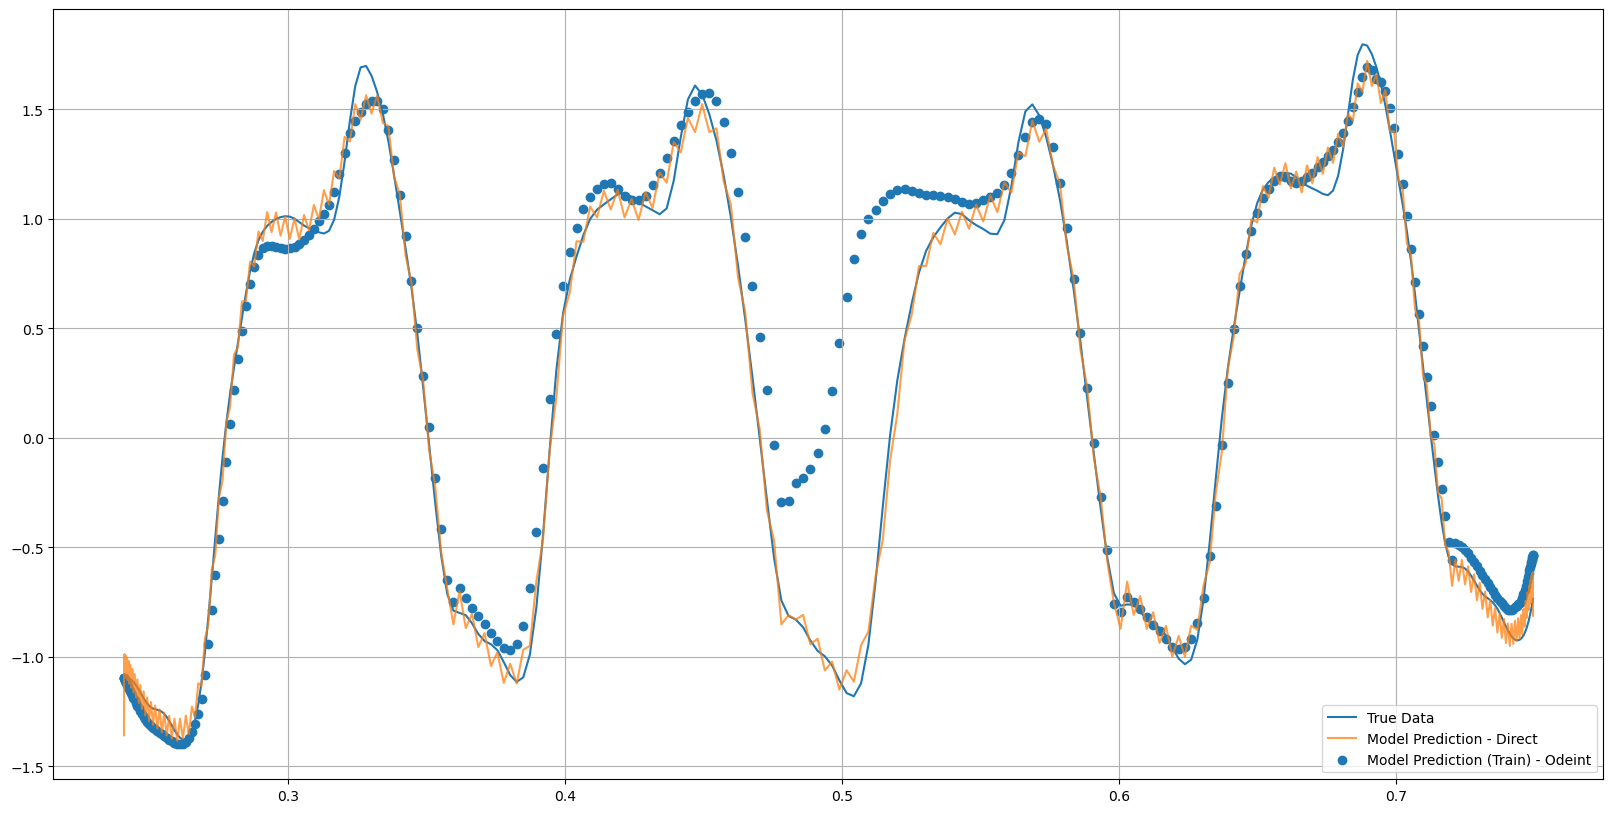

In [347]:
y0 = ys[0]
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)

plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [348]:
import ode_solver_pyomo
importlib.reload(ode_solver_pyomo)
DirectODESolver = ode_solver_pyomo.DirectODESolver

trained_weights_biases = ode_model.extract_weights()

W1 = trained_weights_biases['W1']
b1 = trained_weights_biases['b1']
W2 = trained_weights_biases['W2']
b2 = trained_weights_biases['b2']

trained_weights = [W1, W2]
trained_biases = [b1, b2]

# Define the layer sizes as per your neural network architecture
layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]

tol = 1e-5
params = {"tol":1e-5, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            "acceptable_iter": 0,  
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 300 }

initial_state = (u_model[0])
# Initialize the direct ODE solver
direct_solver = DirectODESolver(np.array(ts), layer_sizes, trained_weights, trained_biases, initial_state, 
                                time_invariant=True, extra_input=np.array(Xs), params=params,
                                discretization_scheme = "BACKWARD")
# BACKWARD; LAGRANGE-LEGENDRE; 

# Build and solve the model
direct_solver.build_model()
solver_info = direct_solver.solve_model()

# Extract the solution
t_solution, y_solution = direct_solver.extract_solution()
print(len(y_solution))


Ipopt 3.14.16: tol=1e-05
dual_inf_tol=1e-05
compl_inf_tol=1e-05
constr_viol_tol=1e-05
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=300


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     1527
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      306

Total number of variables............................:      612
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
 

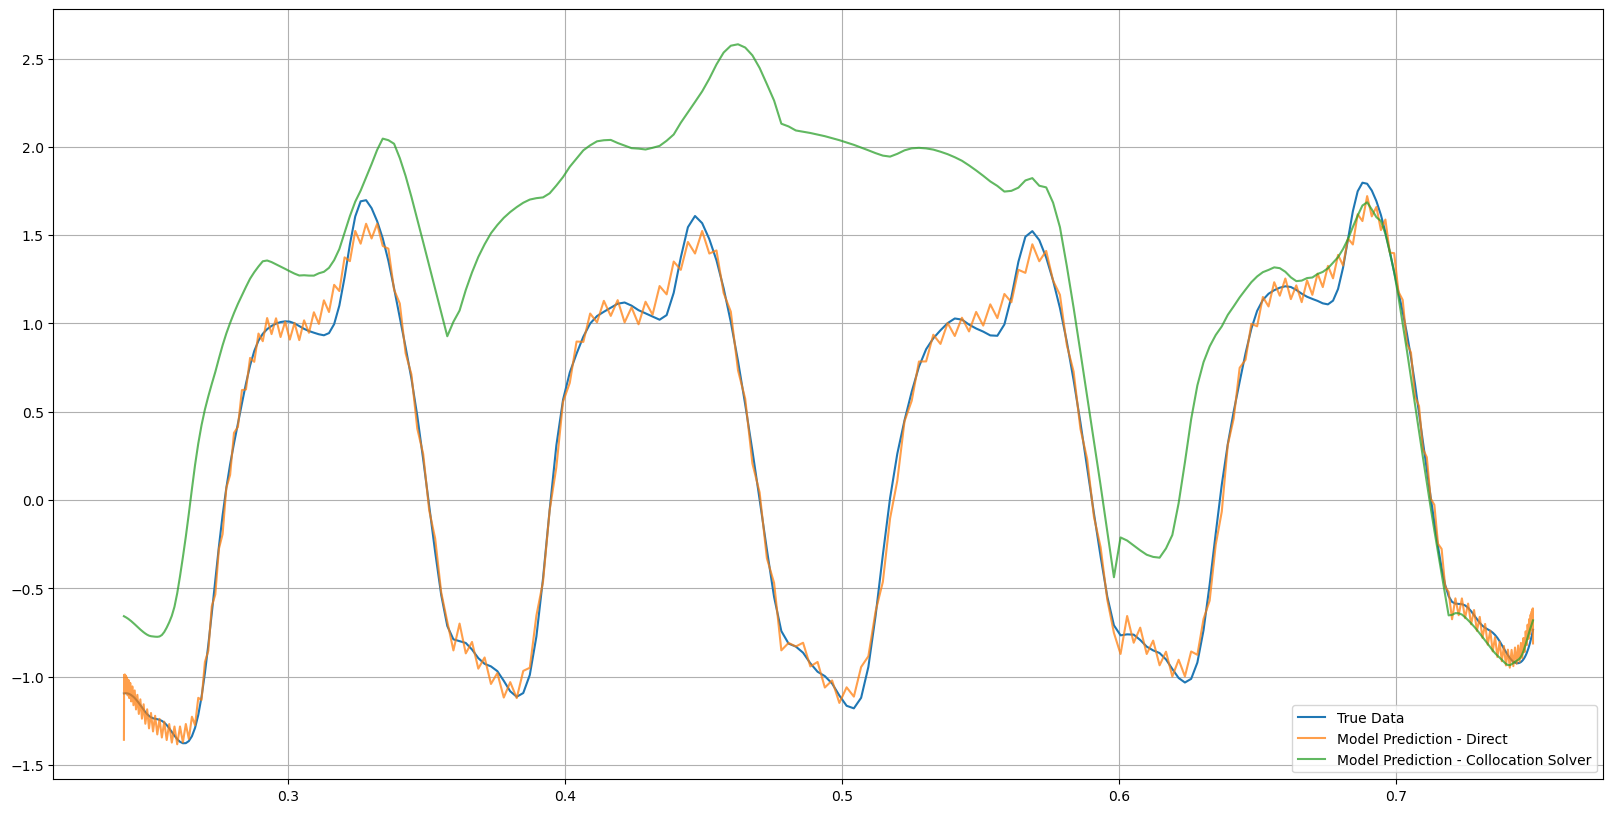

In [349]:
t_temp = np.linspace(min(ts), max(ts), len(y_solution))

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.plot(t_solution, y_solution, label='Model Prediction - Collocation Solver', alpha = 0.75)

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

----